In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml-2/bin/python
/home/ata/miniconda3/envs/ml-2/bin/jupyter


In [3]:
import sys
assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-01-07 22:20:34.902115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 22:20:34.934026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736270434.954836   79228 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736270434.960720   79228 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 22:20:34.992657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
# from dotenv import load_dotenv
# from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

#### Fetch pair data

In [6]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
time_delta = 12
db_name = pair + "_1min_" + str(time_delta) + "weeks.db"
db_name = "BTCUSDT_1min_dry_run.db"             # For dry run testing
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()


#### Fecth Data from Binance

In [3]:

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
# start_date = server_time_dt - timedelta(hours=10)
start_date = server_time_dt - timedelta(weeks=time_delta)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    df = data
else:
    print("No data found!!!.")

Fetching data from Binance API...


#### Fetch data from db

In [7]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

In [8]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2024-10-07 15:14:00,63800.01,63806.82,63752.00,63773.50,17.86195
2024-10-07 15:15:00,63773.50,63775.20,63655.62,63666.00,41.48581
2024-10-07 15:16:00,63666.00,63690.00,63525.00,63598.01,86.80723
2024-10-07 15:17:00,63598.00,63620.00,63575.00,63592.67,20.62473
2024-10-07 15:18:00,63592.67,63700.54,63585.01,63700.54,28.19269


#### Test/Train Splot

Feature engineering

In [9]:
# Feature Engineering (mind the order since some features are depended on others)
bf = BatchFeatures()
bf.calculate_sma(df)
bf.calculate_ema(df)
bf.calculate_rsi(df)
bf.calculate_macd(df)
bf.calculate_bollinger_bands(df)
bf.calculate_atr(df)
bf.calculate_volume_features(df)
bf.calculate_roc(df)
bf.calculate_lagged_features(df)
bf.calculate_candle_features(df)
bf.calculate_stochastic_oscillator(df)
bf.calculate_williams_r(df)
bf.calculate_moving_average_crossover(df)
bf.calculate_historical_volatility(df)
bf.calculate_on_balance_volume(df)
bf.calculate_money_flow_index(df)
bf.calculate_croc(df)

# drop NaNs
df.dropna(inplace=True)

#### Define target 

In [10]:
# Predict the percentage price change over the next 'n' candles
nn = 5
# df['target'] = (df['close'].shift(nn) - df['close'])
df['target'] = (df['close'].shift(nn) - df['close']) / df['close'] * 100
# df['target'] = (df['ema_5'].shift(nn) - df['ema_5']) / df['ema_5'] * 100
df.dropna(inplace=True)

In [9]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Split the df into three parts, train, validation and testing

In [10]:
1920*4

7680

In [11]:
# Define split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Use only last 3 hrs data for training, testing & validation
df_recent = df.copy().iloc[-1920*4:]


# Calculate split indices
n = len(df_recent)
train_end = int(train_ratio * n)
val_end = train_end + int(val_ratio * n)

# Perform the splits
train_data = df_recent.iloc[:train_end]
val_data = df_recent.iloc[train_end:val_end]
test_data = df_recent.iloc[val_end:]

scaler = StandardScaler()
# Fit and transform the training data
train_data_scaled = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
joblib.dump(scaler, 'lstm_scaler.pkl')  # Save the fitted scaler

# Transform the validation data
val_data_scaled = scaler.transform(val_data)
val_data = pd.DataFrame(val_data_scaled, columns=val_data.columns, index=val_data.index)

# Transform the test data
test_data_scaled = scaler.transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data.columns, index=test_data.index)

Randomize the time sequences

In [12]:
# Sequence length (5 hours = 300 instances for 1-minute resolution)
seq_length = 60
batch_size = 32*4

# Create time series datasets
tf.random.set_seed(42)  # Ensures reproducibility

# Training dataset
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data.iloc[:-seq_length].to_numpy(),  # Exclude the last 'seq_length' rows for input
    targets=train_data.iloc[seq_length:]['target'].to_numpy(),  # Shift target by 'seq_length'
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation dataset
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data.iloc[:-seq_length].to_numpy(),
    targets=val_data.iloc[seq_length:]['target'].to_numpy(),
    sequence_length=seq_length,
    batch_size=batch_size
)


I0000 00:00:1736270454.735577   79228 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    # opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

Simple RNN Test

In [14]:
for x, y in train_ds.take(1):
    print("Input shape:", x.shape)  # Should be (batch_size, time_steps, features)
    print("Target shape:", y.shape)


Input shape: (128, 60, 52)
Target shape: (128,)


2025-01-07 22:20:59.194202: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, input_shape=[None, 52]),
    tf.keras.layers.LSTM(64, activation="tanh"),
    tf.keras.layers.Dense(1)
])


In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="relu", return_sequences=True, input_shape=[None, 52]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


/home/ata/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.3777 - mae: 0.7211 - val_loss: 0.0852 - val_mae: 0.3107
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2375 - mae: 0.5440 - val_loss: 0.0599 - val_mae: 0.2566
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1899 - mae: 0.4755 - val_loss: 0.0548 - val_mae: 0.2410
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1669 - mae: 0.4446 - val_loss: 0.0478 - val_mae: 0.2257
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1653 - mae: 0.4406 - val_loss: 0.0461 - val_mae: 0.2208
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1502 - mae: 0.4171 - val_loss: 0.0482 - val_mae: 0.2279
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1473 - mae: 0.4122 - val_loss: 0.0500 - val_mae: 0.2361
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1467 - mae: 0.4121 - val_loss: 0.0444 - val_mae: 0.2190
Epoch 9/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1428 -

0.19901533424854279

In [46]:
print(f"Target abs mean: {train_data['target'].abs().mean()}")
print(f"Target std deviation: {train_data['target'].std()}")
print(f"Target min: {train_data['target'].min()}")
print(f"Target max: {train_data['target'].max()}")


Target abs mean: 0.7096495273887106
Target std deviation: 1.0001085246082746
Target min: -10.012646711491117
Target max: 4.9216233530497755


In [47]:
# Save the model
joblib.dump(model, 'lstm_5candles_1min.joblib')

['lstm_5candles_1min.joblib']

In [16]:
# load the best model
model = joblib.load('lstm_5candles_1min.joblib')

In [17]:
INITIAL_BALANCE=1000

In [18]:
def simulate_trades(signals, prices, initial_balance=1000):
    """
    Simulates trades based on signals and actual price changes.

    Args:
        actual_changes (list or pd.Series): Actual percentage changes (not predicted).
        signals (list): List of trading signals ("Buy", "Sell", "Hold").
        prices (list or pd.Series): Actual price values for the asset.
        initial_balance (float): Starting balance of the trading account.

    Returns:
        float: Final balance or cumulative profit.
    """
    balance = INITIAL_BALANCE
    position = 0  # Tracks the number of stocks held
    entry_price = None  # Store the price when a "Buy" was executed
    
    for i, signal in enumerate(signals):
        if signal == "Buy" and balance > 0:
            # Execute a buy
            entry_price = prices.iloc[i]  # Use .iloc for positional indexing
            position = balance / entry_price  # Buy with all available balance
            balance = 0  # All balance used to buy
        elif signal == "Sell" and position > 0:
            # Execute a sell
            exit_price = prices.iloc[i]  # Use .iloc for positional indexing
            balance = position * exit_price  # Convert position to cash
            position = 0  # Clear position
            entry_price = None  # Reset entry price after selling

                    # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

    # If there's a remaining position at the end, calculate its value
    if position > 0 and entry_price is not None:
        balance += position * prices.iloc[-1]  # Use .iloc for positional indexing

    return balance - INITIAL_BALANCE  # Return cumulative profit


In [100]:
# Generate sequences for LSTM input
seq_length = 60  # Replace with the sequence length used during training
X_test = []
y_test = []

for i in range(seq_length, len(test_data_scaled)-nn):
    X_test.append(test_data_scaled.iloc[i-seq_length:i].to_numpy())  # Create sequence
    y_test.append( (test_data.iloc[i + nn]['close'] - test_data.iloc[i]['close']) /test_data.iloc[i]['close'] * 100)  # Price change nn candles ahead

X_test = np.array(X_test)
y_test = np.array(y_test)

# Unscale predictions
predictions_scaled = model.predict(X_test)  # Predictions are in scaled space
predictions = scaler.inverse_transform(
    np.hstack([np.zeros((predictions_scaled.shape[0], test_data_scaled.shape[1]-1)), predictions_scaled])
)[:, -1]  # Unscale the 'close' column only

# Prepend 'nn' NaNs to align predictions with actual changes
predictions = np.concatenate((-1*predictions, np.full(nn, np.nan)))
# predictions = -1*predictions 


# Combine predictions and actual values
results_df = test_data.iloc[seq_length:].copy()
results_df['Predicted Change'] = predictions / 100  # Model output: predicted change in price
# results_df['Actual Change'] = np.concatenate((np.full(nn, np.nan), y_test)) / 100   # Actual change in price (target)

# Calculate predicted price
results_df['Predicted Price'] = test_data['close'] * (1 + results_df['Predicted Change'])

# Optionally include actual future prices for comparison
# results_df['Actual Price'] = results_df['close'] * (1 + results_df['Actual Change'])  # Actual future close price

results_df.dropna(inplace=True)  # Remove NaNs caused by shifting

# Define buy and sell thresholds (e.g., absolute differences in predicted vs. actual price)
sell_thresholds = np.arange(-0.015, -0.00001, 0.0001)  # Thresholds for when to "Buy"
buy_thresholds = np.arange(0.0001, 0.015, 0.00001)   # Thresholds for when to "Sell"

best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))

for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            "Sell" if pred < sell_th else "Buy" if pred > buy_th else "Hold"
            for pred in results_df['Predicted Change']
        ]

        
        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['Predicted Price'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Best Buy Threshold: 0.00658, Best Sell Threshold: -0.015
Best Performance: 0.0


#### Beck Testing 

In [ ]:
# Define buy & sell thrsholds
buy_threshold = 0.00658
sell_threshold = -0.015
# Generate signals with reversed logic
trading_signals = [
    "Sell" if pred < sell_threshold else "Buy" if pred > buy_threshold else "Hold"
    for pred in results_df['Predicted Change']
]

balance = INITIAL_BALANCE
position = 0  # No stock initially
trading_log = []  # To store completed trades



results_df['Signal'] = trading_signals

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
results_df['open'] = df.loc[results_df.index, 'open']
results_df['close'] = df.loc[results_df.index, 'close']

results_df.dropna(inplace=True)

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['Predicted Price']  # Use 'open' price for Buy
    # volume = balance / price if signal == "Buy" and balance > 0 else position  # Calculate volume

    if signal == "Buy" and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = balance / price
        position = buy_volume  # Update position
        balance = 0  # All money is invested

    elif signal == "Sell" and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = price  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['Predicted Price']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - INITIAL_BALANCE:.2f}")



Final Balance: $880.38
Net Profit: $-119.62


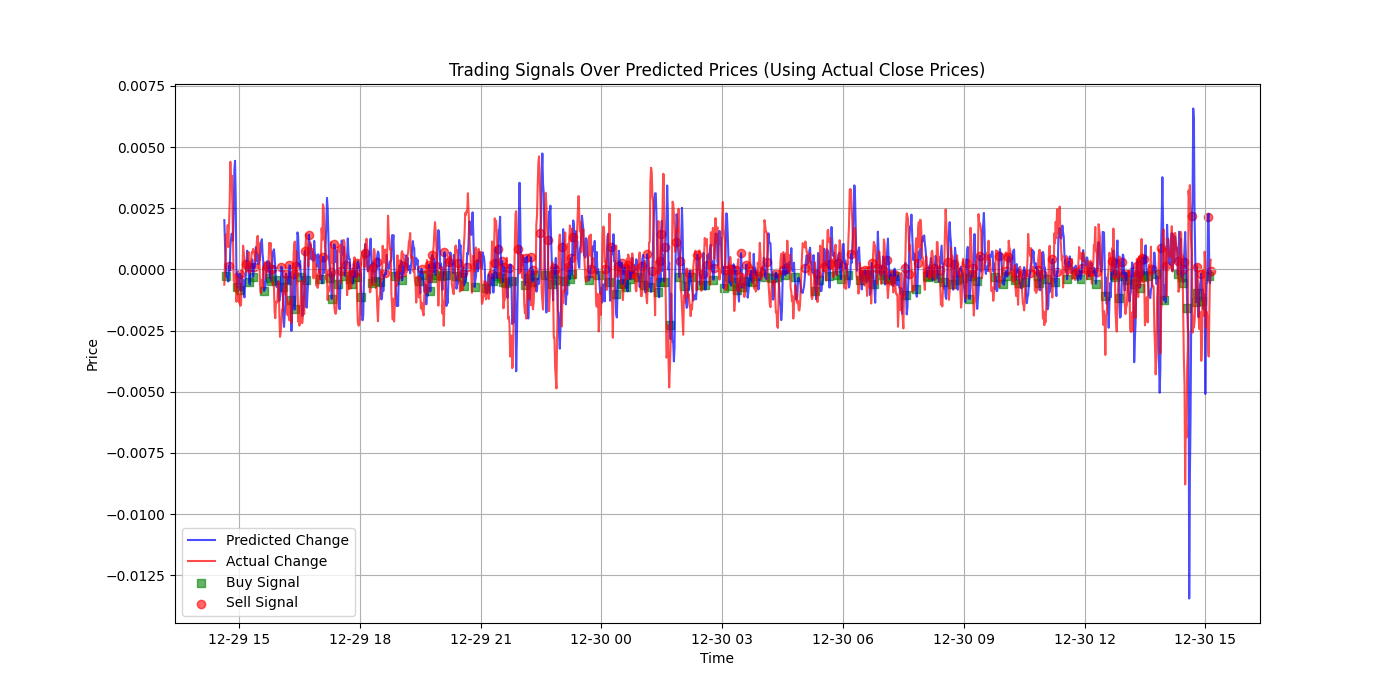

In [94]:
# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Change'], label='Predicted Change', color='blue', alpha=0.7)
plt.plot(results_df.index, y_test/100, label='Actual Change', color='red', alpha=0.7)


# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Change'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Change'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# results_df['Actual Future Price'] = results_df['close']  # Actual future close price

plt.clf()
plt.figure(figsize=(12, 7))
results_df['Predicted Price'].plot()
# results_df['Actual Change'].plot()
results_df['close'].plot()
plt.legend()
plt.show()

In [53]:
results_df['Predicted Price'].head()

timestamp
2024-12-29 14:38:00    94440.628095
2024-12-29 14:39:00    94344.048604
2024-12-29 14:40:00    94206.864573
2024-12-29 14:41:00    94171.268724
2024-12-29 14:42:00    94186.476624
Name: Predicted Price, dtype: float64

In [63]:
results_df.shift(-nn).head()

,open,high,low,close,volume,sma_10,sma_50,ema_10,ema_5,ema_50,...,ma_crossover,log_return,historical_volatility,price_change,obv,mfi,croc_10,target,Predicted Change,Predicted Price
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-29 14:38:00,94216.25,94231.67,94192.06,94192.07,10.22624,94224.952,94702.9146,94240.255025,94208.332274,94580.192300,...,-477.9626,-0.000257,0.001028,-24.17,37049.900927,22.392575,0.036778,0.062404,-0.000341,94159.919530
2024-12-29 14:39:00,94192.06,94291.58,94192.06,94257.42,10.00140,94225.677,94689.1642,94243.375930,94224.694849,94567.534562,...,-463.4872,0.000694,0.000651,65.35,37059.902327,28.083916,0.054021,-0.019627,-0.000497,94210.539606
2024-12-29 14:40:00,94257.43,94257.43,94192.99,94230.52,8.11583,94222.738,94674.9158,94241.038488,94226.636566,94554.318305,...,-452.1778,-0.000285,0.000566,-26.90,37051.786497,34.843905,0.007069,-0.037971,0.000142,94243.901870
2024-12-29 14:41:00,94230.52,94360.01,94230.52,94331.61,26.51145,94233.479,94662.9454,94257.506035,94261.627711,94545.584646,...,-429.4664,0.001072,0.000495,101.09,37078.297947,44.428884,0.030169,-0.143748,-0.000047,94327.170485
2024-12-29 14:42:00,94331.62,94388.70,94307.05,94310.95,27.74814,94241.933,94650.9842,94267.223120,94278.068474,94536.383287,...,-409.0512,-0.000219,0.000500,-20.66,37050.549807,67.540559,0.057511,-0.100423,0.000943,94399.851969


In [64]:
results_df.head()

,open,high,low,close,volume,sma_10,sma_50,ema_10,ema_5,ema_50,...,ma_crossover,log_return,historical_volatility,price_change,obv,mfi,croc_10,target,Predicted Change,Predicted Price
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-29 14:38:00,94226.41,94267.80,94220.00,94250.85,19.85160,94272.250,94775.3540,94301.239716,94244.914769,94662.824079,...,-503.1040,0.000259,0.001062,24.44,37062.540867,25.141132,-0.391090,-0.107012,0.002014,94440.628095
2024-12-29 14:39:00,94250.85,94263.73,94215.02,94238.92,11.37175,94230.416,94761.3966,94289.908859,94242.916513,94646.200390,...,-530.9806,-0.000127,0.001062,-11.93,37051.169117,25.446599,-0.414272,0.011938,0.001116,94344.048604
2024-12-29 14:40:00,94238.92,94252.00,94163.12,94194.74,23.21600,94214.572,94747.1494,94272.605430,94226.857675,94628.496061,...,-532.5774,-0.000469,0.001062,-44.18,37027.953117,25.270992,-0.343859,0.069186,0.000129,94206.864573
2024-12-29 14:41:00,94194.75,94250.36,94184.10,94196.01,16.10498,94210.422,94732.4016,94258.678988,94216.575117,94611.535823,...,-521.9796,0.000013,0.001060,1.27,37044.058097,23.173566,-0.217971,0.029927,-0.000263,94171.268724
2024-12-29 14:42:00,94196.02,94278.04,94196.01,94216.24,16.06907,94220.744,94717.9906,94250.962808,94216.463411,94596.034026,...,-497.2466,0.000215,0.001034,20.23,37060.127167,24.479498,-0.034094,0.010794,-0.000316,94186.476624


In [27]:
# Save the model
joblib.dump(best_model, 'best_model_10candles_1min.joblib')

['best_model_10candles_1min.joblib']

#### Best Model Prediction

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


Mean Squared Error (MSE): 0.005233071057849914
Mean Absolute Error (MAE): 0.04958422219780115
R² Score: 0.000663164314149034


#### Generate Predictions

In [28]:
# Use the model's predictions
predictions = pd.DataFrame(y_pred)  # Predicted percentage changes
y_pred_train  = pd.DataFrame(best_model.predict(X_train))  # Predicted percentage changes

### Trading Signal Generation & Back Testing

In [29]:
INITIAL_BALANCE = 100  # Starting with $10,000

#### Trade Simulator

#### Generate a Search Space

In [59]:
import numpy as np
buy_thresholds = np.arange(-2.0, -0.031, 0.01)
sell_thresholds = np.arange(0.01, 2.0, 0.01)

# Add signals to a DataFrame for analysis
results_df = X_test.copy()
results_df['Predicted Change'] = predictions.shift(-nn).values
results_df['Predicted Price'] = results_df['close_lag_1'] * (1 + results_df['Predicted Change'] / 100)
results_df.dropna(inplace=True)

#### Evaluate Thresholds

In [72]:
best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))

for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            "Buy" if pred < buy_th else "Sell" if pred > sell_th else "Hold"
            for pred in results_df['Predicted Change'].values
        ]
        
        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['Predicted Price'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


Best Buy Threshold: -2.0, Best Sell Threshold: 0.01
Best Performance: 0.0


In [101]:
# Save the model
joblib.dump(best_model, 'best_model_10candles_reduced_1min.joblib')

['best_model_10candles_reduced_1min.joblib']

### Analysis

#### Compute Baseline

In [41]:
# Get starting and ending prices
initial_price = results_df.iloc[0]['close']  # Opening price at the first date
final_price = results_df.iloc[-1]['close']  # Closing price at the last date

# Calculate number of shares purchased with initial balance
shares = INITIAL_BALANCE / initial_price

# Calculate final balance
final_balance_baseline = shares * final_price

# Calculate profit/loss for the baseline strategy
profit_loss_baseline = final_balance_baseline - INITIAL_BALANCE

# Print results
print(f"Baseline Final Balance: ${final_balance_baseline:.2f}")
print(f"Baseline Strategy Profit/Loss: ${profit_loss_baseline:.2f}")


Baseline Final Balance: $96.54
Baseline Strategy Profit/Loss: $-3.46


#### Baseline Comparison

In [42]:
# Assuming `profit_loss_estimator` is calculated from your trading log
profit_loss_estimator = trading_log_df['Profit/Loss'].sum()

# Calculate difference and percentage improvement
difference = profit_loss_estimator - profit_loss_baseline
improvement_percentage = (difference / abs(profit_loss_baseline)) * 100 if profit_loss_baseline != 0 else None

# Print comparison
print(f"Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Difference vs. Baseline: ${difference:.2f}")
if improvement_percentage is not None:
    print(f"Performance Improvement: {improvement_percentage:.2f}%")
else:
    print("Baseline profit/loss is zero, percentage improvement cannot be calculated.")


Estimator Profit/Loss: $67421.74
Difference vs. Baseline: $67425.20
Performance Improvement: 1947511.90%


In [43]:
# Calculate momentum (percentage change in price)
momentum_threshold = 0.01  # 1% change as momentum threshold
momentum_signals = results_df['close'].pct_change()  # Calculate percentage change
momentum_trades = momentum_signals[momentum_signals.abs() > momentum_threshold]

# Initialize profit/loss calculation for momentum strategy
momentum_profit_loss = 0
balance = INITIAL_BALANCE
position = 0

# Iterate through momentum trades
for idx, change in momentum_trades.items():  # Use .items() for Series iteration
    price = results_df.loc[idx, 'close']
    if change > 0 and balance > 0:  # Buy signal
        position = balance / price
        balance = 0
    elif change < 0 and position > 0:  # Sell signal
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

momentum_profit_loss = balance - INITIAL_BALANCE

print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")


Momentum Strategy Profit/Loss: $0.54


In [44]:
rolling_window = 20
results_df['SMA'] = results_df['close'].rolling(rolling_window).mean()
results_df['Deviation'] = results_df['close'] - results_df['SMA']

# Drop NaN rows to avoid issues with rolling mean
mean_reversion_trades = results_df.dropna()

# Generate signals explicitly with .loc
mean_reversion_trades.loc[:, 'Signal'] = mean_reversion_trades['Deviation'].apply(
    lambda x: 'Buy' if x < 0 else 'Sell'
)

# Simulate mean-reversion trading
balance = INITIAL_BALANCE
position = 0
mean_reversion_profit_loss = 0

for idx, row in mean_reversion_trades.iterrows():
    price = row['close']
    signal = row['Signal']
    if signal == 'Buy' and balance > 0:  # Buy
        position = balance / price
        balance = 0
    elif signal == 'Sell' and position > 0:  # Sell
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

mean_reversion_profit_loss = balance - INITIAL_BALANCE

print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")


Mean-Reversion Strategy Profit/Loss: $-11.26


In [45]:
print(f"ML Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Baseline Profit/Loss: ${profit_loss_baseline:.2f}")
print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")
print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")

ML Estimator Profit/Loss: $67421.74
Baseline Profit/Loss: $-3.46
Momentum Strategy Profit/Loss: $0.54
Mean-Reversion Strategy Profit/Loss: $-11.26


### Visualizations

##### Plot Predicted Change

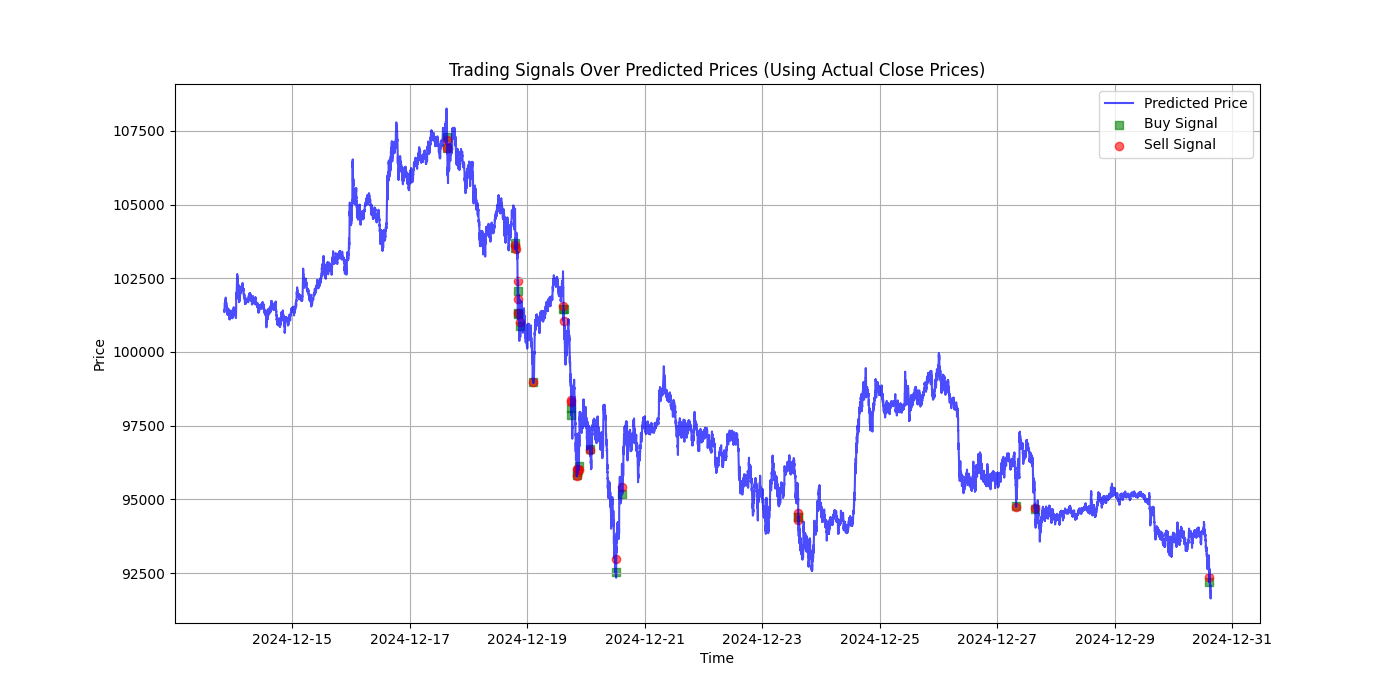

In [44]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Price'], label='Predicted Price', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Price'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Price'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


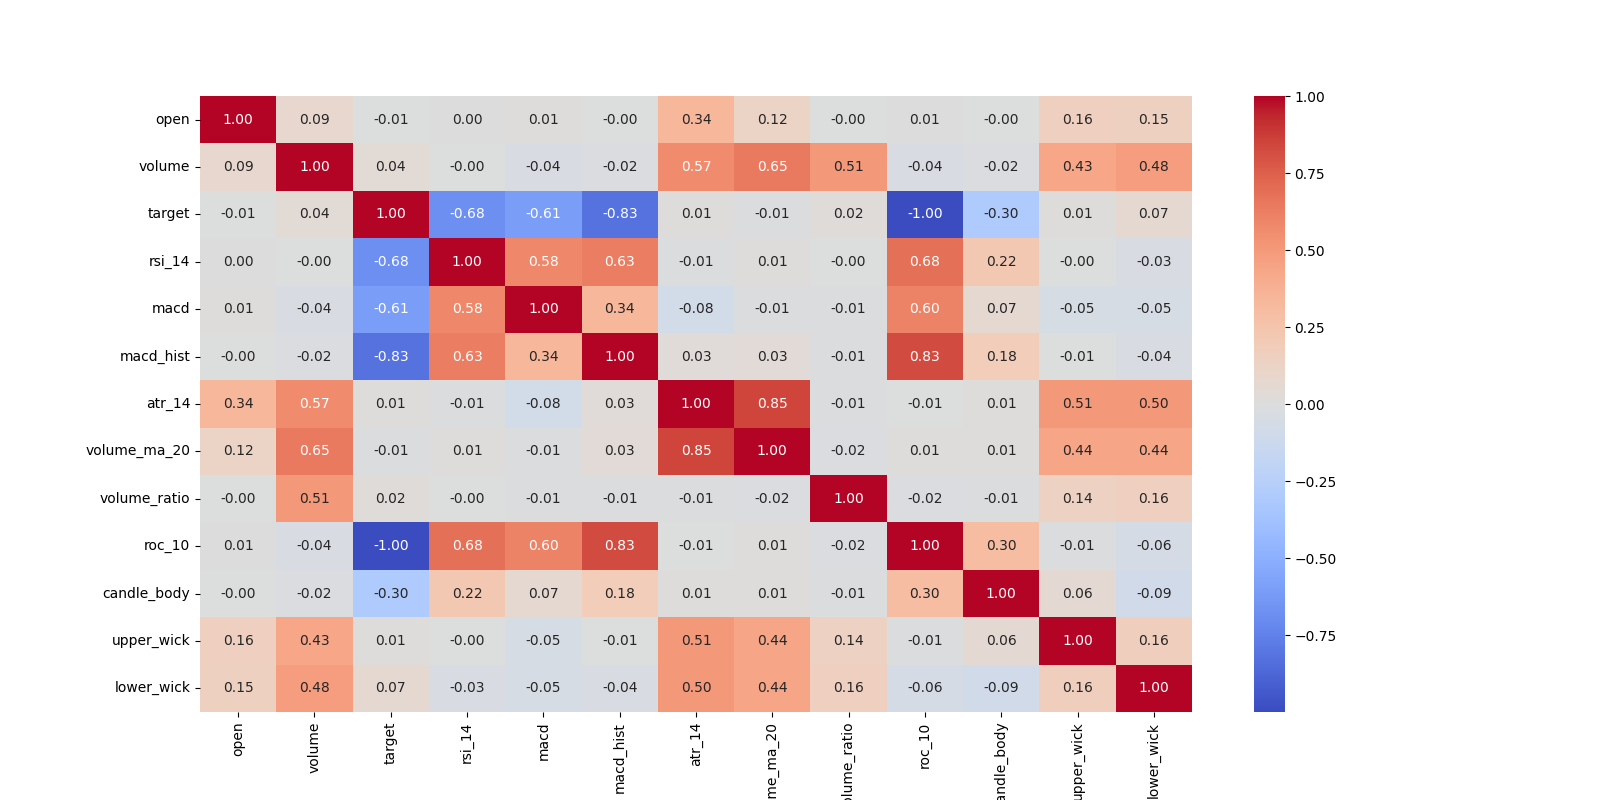

In [39]:
corr_matrix = df_reduced.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### Parameter Optimization

In [42]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}

# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.005, test=-0.027) total time=   0.3s
[CV 2/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.004) total time=   0.7s
[CV 3/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.002) total time=   1.0s
[CV 4/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.003) total time=   1.3s
[CV 5/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.006, test=-0.005) total time=   1.8s
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [3, 5, 10],
                         'regressor__max_features': [5, 10, 15],
                         'regressor__n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

#### Save GridSearch Results

In [ ]:

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_results_1min_reduced.pkl')

### Dry Run Analysis

In [10]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
import pytz
%matplotlib widget

In [90]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
db_name = "BTCUSDT_1min_dry_run_analysis.db"             # For dry run testing
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Fixed start and end times for the 8-hour dry run test
start_date = datetime.strptime("2024-12-30 02:43:00", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2024-12-30 09:47:00", "%Y-%m-%d %H:%M:%S")

# Ensure timezone is set to UTC
start_date = start_date.replace(tzinfo=pytz.UTC)
end_date = end_date.replace(tzinfo=pytz.UTC)

start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
if data is not None and not data.empty:
    binance_client.store_data_to_db(pair, data)
    df = data
    print("Data fetched and stored successfully.")
else:
    print("No data found!!!.")


Fetching data from Binance API...
Data fetched and stored successfully.


In [ ]:
#Fetch data from db
# df = binance_client.fetch_data_from_db(pair)

batch_feature = BatchFeatures()
batch_feature.calculate_sma(df)
batch_feature.calculate_ema(df)
batch_feature.calculate_rsi(df)
batch_feature.calculate_macd(df)
batch_feature.calculate_bollinger_bands(df)
batch_feature.calculate_atr(df)
batch_feature.calculate_volume_features(df)
batch_feature.calculate_roc(df)
batch_feature.calculate_lagged_features(df)
batch_feature.calculate_candle_features(df)
# Drop NaNs
df.dropna(inplace=True)

# Drop Close form test set
X_test = df.drop(['close'], axis=1)

# Load the best model
best_model = joblib.load('best_model_10candles_reduced_1min.joblib')
# The model predicts 'close price' for next 1 hr i.e. 12 candles @ 5_min_interval
span = 10

# Generate predictions
predictions = pd.DataFrame(best_model.predict(X_test))

# Add signals to a DataFrame for analysis
results_df = X_test.copy()
# results_df['Predicted Change'] = predictions.shift(-nn).values
results_df['Predicted Change'] = predictions.values

# Compute predicted prices based on the previous close and Predicted Change
results_df['Predicted Price'] = results_df['close_lag_1'] * (1 + results_df['Predicted Change'] / 100)

# plot the results
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label="Actual Close", alpha=0.8)
plt.plot(results_df['Predicted Price'], label="Predicted", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Percentage Change")
plt.show()


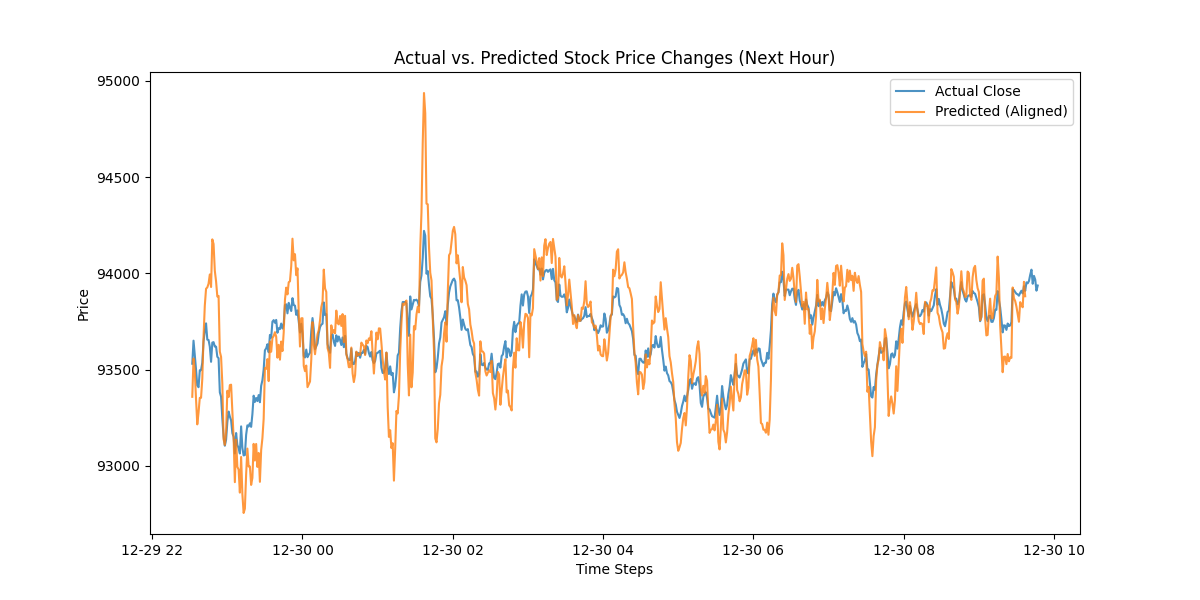

In [91]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

batch_feature = BatchFeatures()
batch_feature.calculate_sma(df)
batch_feature.calculate_ema(df)
batch_feature.calculate_rsi(df)
batch_feature.calculate_macd(df)
batch_feature.calculate_bollinger_bands(df)
batch_feature.calculate_atr(df)
batch_feature.calculate_volume_features(df)
batch_feature.calculate_roc(df)
batch_feature.calculate_lagged_features(df)
batch_feature.calculate_candle_features(df)
# Drop NaNs
df.dropna(inplace=True)

# Drop Close from test set
X_test = df.drop(['close'], axis=1)

# Load the best model
best_model = joblib.load('best_model_10candles_reduced_1min.joblib')
span = 10  # Number of candles ahead the model predicts

# Generate predictions
predictions = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=["Predicted Change"])

# Add predictions to a DataFrame
results_df = df.copy()
results_df['Predicted Change'] = predictions.shift(-span).values  # Shift predictions forward by `span`

# Compute predicted prices based on the previous close and Predicted Change
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the results with proper alignment
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label="Actual Close", alpha=0.8)
plt.plot(results_df['Predicted Price'], label="Predicted (Aligned)", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()


### Misc Code

In [ ]:
import cupy as cp
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)


In [ ]:
def simulate_trades_with_penalty(predicted_changes, signals, initial_balance=1000):
    balance = initial_balance
    position = 0
    trades = 0  # Count the number of trades
    penalty = 0  # Initialize penalty for excessive trading

    for change, signal in zip(predicted_changes, signals):
        if signal == "Buy":
            position += balance / 100
            balance = 0
            trades += 1
        elif signal == "Sell" and position > 0:
            balance += position * (1 + change / 100)
            position = 0
            trades += 1
        # "Hold" means do nothing
    
    balance += position * (1 + predicted_changes.iloc[-1] / 100)
    
    # Apply penalty for excessive trades
    penalty = -0.01 * trades  # Example penalty, adjust as needed
    return balance - initial_balance + penalty


In [8]:
import sqlite3
db_name="binance_data.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()
cursor.execute("PRAGMA journal_mode=DELETE;")
conn.commit()
conn.close()